In [44]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from tqdm import tqdm
import statistics

In [2]:
df=pd.read_csv("D:\Transformer_thesis\Dataset\V_228.csv",header=None)

In [3]:
#!cat /proc/meminfo

In [4]:
#df=df.iloc[:,:100]

In [5]:
df.shape

(12672, 228)

In [6]:
#data=df.iloc[:,:5].values

In [7]:
data=df.values

In [8]:
data.shape

(12672, 228)

In [9]:
def train_test_split(data):

   test_size=1440
   validation_size=1440
   train_data=data[:-test_size - validation_size]

   validation_data=data[-test_size - validation_size:-test_size]
   test_data=data[-test_size:]
   return train_data,validation_data,test_data

In [10]:
def create_train_sequences(data,window_size,forecast_horizon):
  #X=[]
  #y=[]
  X_shape=[(len(data)-window_size-forecast_horizon + 1),window_size]

  y_shape=[(len(data)-window_size-forecast_horizon + 1),forecast_horizon]
  X=np.zeros(X_shape)
  y=np.zeros(y_shape)
  for i in range(len(data)-window_size- forecast_horizon + 1):
        _x = data[i:(i+window_size)]
        #_y = data[i+window_size]
        _y=data[i + window_size:i + window_size + forecast_horizon]
        X[i,:]=_x
        y[i,:]=_y


  return X,y

In [11]:
def create_test_sequences(data, window_size, forecast_horizon):

    num_samples = len(data) // (window_size + forecast_horizon)
    X_shape = (num_samples, window_size)
    y_shape = (num_samples, forecast_horizon)
    X = np.zeros(X_shape)
    y = np.zeros(y_shape)

    for i in range(num_samples):
        start_index = i * (window_size + forecast_horizon)
        end_index_x = start_index + window_size
        end_index_y = end_index_x + forecast_horizon

        _x = data[start_index:end_index_x]
        _y = data[end_index_x:end_index_y]

        X[i, :] = _x
        y[i, :] = _y

    return X, y

In [12]:
"""
def create_test_sequences(data, window_size, forecast_horizon):

    X_shape=[(len(data)-window_size- forecast_horizon + 1),window_size]
    y_shape=[(len(data)-window_size- forecast_horizon + 1),forecast_horizon]
    X=np.zeros(X_shape)
    y=np.zeros(y_shape)
    step_size = window_size + forecast_horizon

    for i in range(0, len(data) - window_size - forecast_horizon + 1, step_size):
        _x = data[i:(i + window_size)]
        _y = data[i + window_size:i + window_size + forecast_horizon]
        X[i,:]=_x
        y[i,:]=_y

    return X, y
"""

'\ndef create_test_sequences(data, window_size, forecast_horizon):\n\n    X_shape=[(len(data)-window_size- forecast_horizon + 1),window_size]\n    y_shape=[(len(data)-window_size- forecast_horizon + 1),forecast_horizon]\n    X=np.zeros(X_shape)\n    y=np.zeros(y_shape)\n    step_size = window_size + forecast_horizon\n\n    for i in range(0, len(data) - window_size - forecast_horizon + 1, step_size):\n        _x = data[i:(i + window_size)]\n        _y = data[i + window_size:i + window_size + forecast_horizon]\n        X[i,:]=_x\n        y[i,:]=_y\n\n    return X, y\n'

In [13]:
#sc=MinMaxScaler()
#df_scaled=sc.fit_transform(data)

In [14]:
#df_scaled.shape

In [15]:
sequence_length=12
horizon=9
batch_size=32
input_size=1
hidden_size=64
output_size=1
ff_hiddensize=64
mask_flag=None
attn_head=8
start_dec_token_len=6
test_size=1440
validation_size=1440

In [16]:
df.iloc[:,0]

0        71.1
1        68.1
2        68.0
3        68.3
4        68.9
         ... 
12667    70.3
12668    69.9
12669    68.9
12670    69.2
12671    68.6
Name: 0, Length: 12672, dtype: float64

In [17]:

train_seq_x=np.zeros([df.shape[1], (len(df)-validation_size-test_size-sequence_length-horizon+1) , sequence_length ])
train_seq_y=np.zeros([df.shape[1], (len(df)-validation_size-test_size-sequence_length-horizon+1) , horizon])
valid_seq_x=np.zeros([df.shape[1], validation_size-sequence_length-horizon+1  , sequence_length ])
valid_seq_y=np.zeros([df.shape[1], validation_size-sequence_length-horizon+1 , horizon ])
test_seq_x=np.zeros([df.shape[1], test_size // (sequence_length + horizon), sequence_length ])
test_seq_y=np.zeros([df.shape[1],  test_size // (sequence_length + horizon) , horizon])
for i in range(df.shape[1]):
  train_data,validation_data,test_data = train_test_split(df.iloc[:,i])
  #print(train_data.shape)
  #break

  train_x,train_y=create_train_sequences(train_data,sequence_length,horizon)


  train_seq_x[i,:,:]=train_x
  train_seq_y[i,:,:]=train_y
  #train_seq_x.append(train_x)
  #train_seq_y.append(train_y)

  valid_x,valid_y=create_train_sequences(validation_data,sequence_length,horizon)
  valid_seq_x[i,:,:]=valid_x
  valid_seq_y[i,:,:]=valid_y
  #valid_seq_x.append(valid_x)
  #valid_seq_y.append(valid_y)

  test_x,test_y=create_test_sequences(test_data,sequence_length,horizon)
  test_seq_x[i,:,:]=test_x
  test_seq_y[i,:,:]=test_y
  #test_seq_x.append(test_x)
  #test_seq_y.append(test_y)


<ipython-input-10-899fa6672d57>:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  _x = data[i:(i+window_size)]
<ipython-input-10-899fa6672d57>:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  _y=data[i + window_size:i + window_size + forecast_horizon]
<ipython-input-11-887b06378f81>:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` looku

In [18]:
X_train=torch.tensor(train_seq_x,dtype=torch.float32)
y_train=torch.tensor(train_seq_y,dtype=torch.float32)
X_valid=torch.tensor(valid_seq_x,dtype=torch.float32)
y_valid=torch.tensor(valid_seq_y,dtype=torch.float32)
X_test=torch.tensor(test_seq_x,dtype=torch.float32)
y_test=torch.tensor(test_seq_y,dtype=torch.float32)

In [19]:
y_train.shape

torch.Size([228, 9772, 9])

In [20]:
X_train=X_train.unsqueeze(-1)
X_train=X_train.view(-1,X_train.size(2),X_train.size(3))

y_train=y_train.unsqueeze(-1)
y_train=y_train.view(-1,y_train.size(2),y_train.size(3))

X_valid=X_valid.unsqueeze(-1)
X_valid=X_valid.view(-1,X_valid.size(2),X_valid.size(3))

y_valid=y_valid.unsqueeze(-1)
y_valid=y_valid.view(-1,y_valid.size(2),y_valid.size(3))

X_test=X_test.unsqueeze(-1)
y_test=y_test.unsqueeze(-1)
"""
X_test=X_test.unsqueeze(-1)
X_test=X_test.view(-1,X_test.size(2),X_test.size(3))

y_test=y_test.unsqueeze(-1)
y_test=y_test.view(-1,y_test.size(2),y_test.size(3))
"""

'\nX_test=X_test.unsqueeze(-1)\nX_test=X_test.view(-1,X_test.size(2),X_test.size(3))\n\ny_test=y_test.unsqueeze(-1)\ny_test=y_test.view(-1,y_test.size(2),y_test.size(3))\n'

In [21]:
class TimeseriesDataset(Dataset):
  def __init__(self,X,y):
    self.X=X
    self.y=y
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

In [22]:
train_dataset=TimeseriesDataset(X_train,y_train)
valid_dataset=TimeseriesDataset(X_valid,y_valid)
test_dataset=TimeseriesDataset(X_test,y_test)

In [23]:
train_loader=DataLoader(train_dataset,batch_size,drop_last=True)
valid_loader=DataLoader(valid_dataset,batch_size,drop_last=True)
test_loader=DataLoader(test_dataset,batch_size,drop_last=True)

In [24]:
class InputEmbedding(nn.Module):
  def __init__(self,input_size,hidden_size):
      super().__init__()
      self.input_size=input_size
      self.hidden_size=hidden_size
      self.conv1d=nn.Conv1d(in_channels=self.input_size,out_channels=self.hidden_size,padding=1,kernel_size=3,bias=False)
  def forward(self,x):
      embedded_inp=self.conv1d(x.permute(0,2,1))
      return embedded_inp.transpose(1,2)


In [25]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float()* -(math.log(10000.0) / d_model)).exp()
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self,x):
        return self.pe[:,:x.size(1)]

In [26]:
class AttentionLayer(nn.Module):
  def __init__(self,attn_head,hidden_size):
    super().__init__()

    self.attn_head=attn_head
    self.hidden_size=hidden_size
    self.dropout = nn.Dropout(0.1)
    self.linear=nn.Linear(hidden_size,hidden_size)

    self.queries=nn.Linear(hidden_size,hidden_size)
    self.keys=nn.Linear(hidden_size,hidden_size)
    self.values=nn.Linear(hidden_size,hidden_size)

  def forward(self, queries,keys,values,attention_mask):
    b,l,d=queries.shape
    b,s,d=keys.shape

    #Linear projection and creation of multiple heads
    queries=self.queries(queries).view(b,l,self.attn_head,-1)
    keys=self.keys(keys).view(b,s,self.attn_head,-1)
    values=self.values(values).view(b,s,self.attn_head,-1)

    b,l,h,d=queries.shape
    b,s,h,d=keys.shape

    #Calculate attention score
    attention_score=torch.einsum("blhd,bshd->bhls",queries,keys)
    if attention_mask == True:
       mask_shape = [b,1,l,l]
       mask=torch.triu(torch.ones(mask_shape,dtype=torch.bool),diagonal=1)
       attention_score.masked_fill_(mask,-np.inf)
    attention_score_softmax=self.dropout(torch.softmax(attention_score/sqrt(d),dim=-1))
    final_value=torch.einsum("bhls,bshd->blhd",attention_score_softmax,values)

    weighted_attn_val=self.linear(final_value.contiguous().view(b,l,-1))

    return weighted_attn_val

In [27]:
class Encoder(nn.Module):
  def __init__(self,attention,hidden_size,output_size,ff_hiddensize,sequence_length):
    super().__init__()
    self.attention=attention
    self.conv1=nn.Conv1d(in_channels=hidden_size,out_channels=ff_hiddensize,kernel_size=1)
    self.conv2=nn.Conv1d(in_channels=ff_hiddensize,out_channels=hidden_size,kernel_size=1)
    self.linear=nn.Linear(ff_hiddensize,hidden_size)
    self.norm1=nn.LayerNorm(normalized_shape=(sequence_length,hidden_size))
    #self.norm1=nn.LayerNorm(hidden_size)
    self.activation=F.relu
    self.dropout=nn.Dropout(0.1)
  def forward(self,x):
    #self.norm2=nn.LayerNorm(hidden_size)
    attention_x=self.attention(x,x,x,attention_mask=False)
    #add and normalize
    new_x = x + self.dropout(attention_x)
    res_x=x=self.norm1(new_x)
    ##Feed forward NN:
    out=self.conv1(res_x.permute(0,2,1))
    out=self.activation(out)
    out=self.dropout(self.conv2(out).transpose(-1, 1))

    ##Add and normalize:
    new_out=out+res_x
    norm_out=self.norm1(new_out)
    return norm_out

In [28]:
class Decoder(nn.Module):
  def __init__(self,attention,hidden_size,output_size,ff_hiddensize,sequence_length):
    super().__init__()
    self.attention=attention
    #print(f"decoder output size: {output_size}")
    self.conv1=nn.Conv1d(in_channels=hidden_size,out_channels=ff_hiddensize,kernel_size=1)
    self.conv2=nn.Conv1d(in_channels=ff_hiddensize,out_channels=hidden_size,kernel_size=1)
    self.linear1=nn.Linear(hidden_size,ff_hiddensize)
    self.linear2=nn.Linear(ff_hiddensize,hidden_size)
    self.linear3=nn.Linear(hidden_size,output_size)
    self.dropout=nn.Dropout(0.1)
    self.norm1=nn.LayerNorm(hidden_size)
    self.norm2=nn.LayerNorm(hidden_size)
    self.norm3=nn.LayerNorm(hidden_size)
    self.activation=F.relu
  def forward(self,dec_inp,enc_out):
    #calculate self attention by passing dec_inp as Queries,keys and values
    self_attn=self.attention(dec_inp,dec_inp,dec_inp,attention_mask=True)
    #add residual connection and normalize
    residual_add=self_attn+dec_inp
    new_dec_x=self.norm1(residual_add)

    # encoder-decoder attention. Pass key and value as encoder output and queries are output of 1st attention
    enc_dec_atten=self.attention(new_dec_x,enc_out,enc_out,attention_mask=False)
    ## add and normalize
    new_x=enc_dec_atten+self_attn
    norm_x=self.norm2(new_x)

    #FFN
    out=self.conv1(norm_x.permute(0,2,1))
    out=self.activation(out)
    out=self.dropout(self.conv2(out).transpose(-1, 1))

    #add and normalize
    new_x=out+norm_x
    out=self.norm3(new_x)


    #Linear projection
    pred=self.linear3(out)

    return pred


In [29]:
class TransformerModel(nn.Module):
  def __init__(self,input_size,hidden_size,output_size,ff_hiddensize,mask_flag,attn_head,sequence_length):
      super().__init__()
      self.input_size=input_size
      self.hidden_size=hidden_size
      self.output_size=output_size
      self.ff_hidden_size=hidden_size
      self.mask_flag=mask_flag
      self.attn_head=attn_head
      self.sequence_length=sequence_length
      self.embedding=InputEmbedding(self.input_size,self.hidden_size)
      self.positional_embedding=PositionalEmbedding(self.hidden_size)
      #self.encoder=  Encoder( AttentionLayer(self.attn_head,hidden_size),self.hidden_size,self.output_size,self.ff_hidden_size,sequence_length)
      self.encoders = nn.ModuleList([Encoder(AttentionLayer(self.attn_head, hidden_size), hidden_size, output_size, ff_hiddensize, sequence_length)
                                        for _ in range(2)])
      self.decoder=Decoder( AttentionLayer(self.attn_head,hidden_size),self.hidden_size,self.output_size,self.ff_hidden_size,sequence_length )
  def forward(self,x,y):

      #dec inp:
      #input is shifted right and concatenated with 1st time step embedding set as zero
      #decoder_input = torch.cat([torch.zeros_like(y[:, :1, :]), y[:, :-1, :]], dim=1)
      #print(f"x shape: {x[:, -start_dec_token_len:, :].shape}, y shape: {y[:, -horizon:, :].shape}")
      #print(f"x shape: {x.shape}, y shape: {y.shape}")
      #decoder_input = torch.cat((x[:, -start_dec_token_len:, :], torch.zeros_like(y[:, -horizon:, :])), dim=1)
      #decoder_input = torch.cat((x[:, :,-start_dec_token_len ,:], torch.zeros_like(y[:, :,-horizon:, :])), dim=1)
      #print(f"decoder_input shape: {decoder_input.shape}")

      decoder_input=torch.zeros_like(y[:, -horizon:, :])

      #encoder
      inp_embed=self.embedding(x)
      pos_embed=self.positional_embedding(x)
      enc_out=inp_embed + pos_embed

      for encoder in self.encoders:

          enc_out=encoder(enc_out)

      #decoder
      inp_embed=self.embedding(decoder_input)
      pos_embed=self.positional_embedding(decoder_input)
      y_embed= inp_embed + pos_embed
      #print(f"y passed to decoder shape: {y.shape}")
      out=self.decoder(y_embed,enc_out)
      return out


In [30]:
model=TransformerModel(input_size,hidden_size,output_size,ff_hiddensize,mask_flag,attn_head,sequence_length)

In [31]:
loss_fun=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
epochs=10

In [32]:
for epoch in tqdm(range(epochs)):
        model.train()
        for batch_idx, (X,y) in enumerate(train_loader):

            pred=model(X,y)
            pred=pred[:,-horizon:,:]
            optimizer.zero_grad()
            loss=loss_fun(pred,y)
            loss.backward()
            optimizer.step()
        model.eval()
        with torch.no_grad():
          for batch_idx, (X,y) in enumerate(valid_loader):
              pred=model(X,y)
              pred=pred[:,-horizon:,:]
              valid_loss=loss_fun(pred,y)
        if epoch%10==0:
            print(f"epoch: {epoch} train loss:{loss} valid loss:{valid_loss} ")

 10%|████████████▊                                                                                                                   | 1/10 [1:49:02<16:21:24, 6542.75s/it]

epoch: 0 train loss:13.959929466247559 valid loss:42.39255905151367 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [9:31:04<00:00, 3426.41s/it]


In [33]:
#from google.colab import drive
#drive.mount('/content/drive')

In [34]:
import os
plot_dir = 'D:\Transformer_thesis\Plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [35]:
output=[]
ground_truth=[]
pred_series=[]
truth_series=[]
loss=[]
pred_total=[]
y_total=[]


for i in range(X_test.size(0)):
  curent_X_test=X_test[i,:,:,:]
  current_y_test=y_test[i,:,:,:]
  pred=model(curent_X_test,current_y_test)
  pred=pred[:,-horizon:,:]
  pred=pred.reshape(-1,1).detach().numpy()
  current_y_test=current_y_test.reshape(-1,1).detach().numpy()

  loss.append(loss_fun(torch.tensor(pred),torch.tensor(current_y_test)))


  #print(current_y_test[:300])

  plt.figure(figsize=(10, 6))
  plt.plot(current_y_test, label='Ground Truth')
  plt.plot(pred, label='Predicted')
  plt.title(f'Time Series {i+1}: Ground Truth vs Predicted Values')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.grid(True)
  #plt.show()
  plt.savefig(os.path.join(plot_dir, f'Time_Series_{i+1}_plot.png'))
  plt.close()



In [36]:
loss  

[tensor(120.9026),
 tensor(98.8687),
 tensor(41.1994),
 tensor(35.2242),
 tensor(40.0078),
 tensor(103.1763),
 tensor(135.5505),
 tensor(77.5170),
 tensor(50.9829),
 tensor(107.1659),
 tensor(76.4078),
 tensor(67.9115),
 tensor(65.3412),
 tensor(36.1754),
 tensor(55.0546),
 tensor(75.5444),
 tensor(17.9614),
 tensor(12.3237),
 tensor(48.8431),
 tensor(8.1587),
 tensor(22.0332),
 tensor(0.9275),
 tensor(10.6822),
 tensor(44.2705),
 tensor(46.7588),
 tensor(26.4221),
 tensor(10.5214),
 tensor(6.7379),
 tensor(58.8660),
 tensor(92.3481),
 tensor(138.0389),
 tensor(10.5278),
 tensor(14.0587),
 tensor(8.8909),
 tensor(74.2852),
 tensor(22.0545),
 tensor(112.9224),
 tensor(27.9066),
 tensor(25.2081),
 tensor(73.3861),
 tensor(49.8898),
 tensor(26.3116),
 tensor(6.4215),
 tensor(4.9130),
 tensor(6.5692),
 tensor(41.8941),
 tensor(14.9354),
 tensor(14.6191),
 tensor(15.9200),
 tensor(5.8869),
 tensor(21.4743),
 tensor(28.3686),
 tensor(70.6197),
 tensor(23.2179),
 tensor(0.7735),
 tensor(43.87

In [48]:
loss_val=torch.stack(loss,dim=0)
mean_loss=torch.mean(loss_val)
mean_loss

tensor(41.4132)

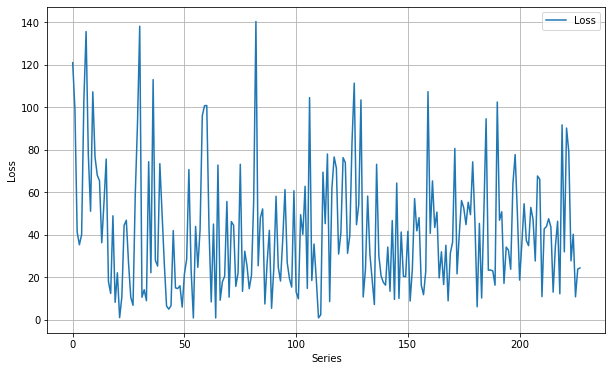

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(loss, label="Loss")



plt.xlabel('Series')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
"""
output=[]
ground_truth=[]
pred_series=[]
truth_series=[]
loss=[]
pred_total=[]
y_total=[]


for i in range(X_test.size(0)):
  curent_X_test=X_test[i,:,:,:]
  current_y_test=y_test[i,:,:,:]
  pred=model(curent_X_test,current_y_test)
  pred=pred[:,-horizon:,:]
  pred=pred.reshape(-1,1).detach().numpy()
  current_y_test=current_y_test.reshape(-1,1).detach().numpy()

  loss.append(loss_fun(torch.tensor(pred),torch.tensor(current_y_test)))
  ""
  plt.figure(figsize=(10, 6))
  plt.plot(current_y_test, label='Ground Truth')
  plt.plot(pred, label='Predicted')
  plt.title(f'Time Series {i+1}: Ground Truth vs Predicted Values')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.grid(True)
"""

'\noutput=[]\nground_truth=[]\npred_series=[]\ntruth_series=[]\nloss=[]\npred_total=[]\ny_total=[]\n\n\nfor i in range(X_test.size(0)):\n  curent_X_test=X_test[i,:,:,:]\n  current_y_test=y_test[i,:,:,:]\n  pred=model(curent_X_test,current_y_test)\n  pred=pred[:,-horizon:,:]\n  pred=pred.reshape(-1,1).detach().numpy()\n  current_y_test=current_y_test.reshape(-1,1).detach().numpy()\n\n  loss.append(loss_fun(torch.tensor(pred),torch.tensor(current_y_test)))\n  ""\n  plt.figure(figsize=(10, 6))\n  plt.plot(current_y_test, label=\'Ground Truth\')\n  plt.plot(pred, label=\'Predicted\')\n  plt.title(f\'Time Series {i+1}: Ground Truth vs Predicted Values\')\n  plt.xlabel(\'Time\')\n  plt.ylabel(\'Value\')\n  plt.legend()\n  plt.grid(True)\n'

In [39]:
loss

[tensor(120.9026),
 tensor(98.8687),
 tensor(41.1994),
 tensor(35.2242),
 tensor(40.0078),
 tensor(103.1763),
 tensor(135.5505),
 tensor(77.5170),
 tensor(50.9829),
 tensor(107.1659),
 tensor(76.4078),
 tensor(67.9115),
 tensor(65.3412),
 tensor(36.1754),
 tensor(55.0546),
 tensor(75.5444),
 tensor(17.9614),
 tensor(12.3237),
 tensor(48.8431),
 tensor(8.1587),
 tensor(22.0332),
 tensor(0.9275),
 tensor(10.6822),
 tensor(44.2705),
 tensor(46.7588),
 tensor(26.4221),
 tensor(10.5214),
 tensor(6.7379),
 tensor(58.8660),
 tensor(92.3481),
 tensor(138.0389),
 tensor(10.5278),
 tensor(14.0587),
 tensor(8.8909),
 tensor(74.2852),
 tensor(22.0545),
 tensor(112.9224),
 tensor(27.9066),
 tensor(25.2081),
 tensor(73.3861),
 tensor(49.8898),
 tensor(26.3116),
 tensor(6.4215),
 tensor(4.9130),
 tensor(6.5692),
 tensor(41.8941),
 tensor(14.9354),
 tensor(14.6191),
 tensor(15.9200),
 tensor(5.8869),
 tensor(21.4743),
 tensor(28.3686),
 tensor(70.6197),
 tensor(23.2179),
 tensor(0.7735),
 tensor(43.87

In [40]:
"""
output=[]
ground_truth=[]
pred_series=[]
truth_series=[]
loss=[]
pred_total=[]
y_total=[]
true_values=[]
predicted_values=[]

for i in range(X_test.size(0)):
  curent_X_test=X_test[i,:,:,:]
  current_y_test=y_test[i,:,:,:]
  pred=model(curent_X_test,current_y_test)
  pred=pred[:,-horizon:,:]
  pred=pred.reshape(-1,1).detach().numpy()
  current_y_test=current_y_test.reshape(-1,1).detach().numpy()


  loss.append(loss_fun(torch.tensor(pred),torch.tensor(current_y_test)))
"""

'\noutput=[]\nground_truth=[]\npred_series=[]\ntruth_series=[]\nloss=[]\npred_total=[]\ny_total=[]\ntrue_values=[]\npredicted_values=[]\n\nfor i in range(X_test.size(0)):\n  curent_X_test=X_test[i,:,:,:]\n  current_y_test=y_test[i,:,:,:]\n  pred=model(curent_X_test,current_y_test)\n  pred=pred[:,-horizon:,:]\n  pred=pred.reshape(-1,1).detach().numpy()\n  current_y_test=current_y_test.reshape(-1,1).detach().numpy()\n\n\n  loss.append(loss_fun(torch.tensor(pred),torch.tensor(current_y_test)))\n'